In [18]:
import matplotlib.pyplot as plt
import matplotlib
import geopandas as gpd
import xarray as xr
import cartopy.crs as ccrs
import warnings
import pandas as pd

In [19]:
#get the IPBES sub regions
# Read the shapefile
shp_dir = "/storage/workspaces/wa_climate/climate_trt/chari/IPBES_subregions/IPBES_Regions_Subregions2.shp"
shp = gpd.read_file(shp_dir)

# Define the region mapping
region_mapping = {
    'Carribean': 'Caribbean & Mesoamerica',
    'Central Africa': 'West, Central, East & South Africa',
    'Central and Western Europe': 'Central and Western Europe',
    'Central Asia': 'Central, North-East & South Asia',
    'East Africa and adjacent islands': 'West, Central, East & South Africa',
    'Eastern Europe': 'Eastern Europe',
    'Mesoamerica': 'Caribbean & Mesoamerica',
    'North Africa': 'North Africa & Western Asia',
    'North America': 'North America',
    'Nort-East Asia': 'Central, North-East & South Asia',
    'Oceania': 'Oceania',
    'South America': 'South America',
    'South Asia': 'Central, North-East & South Asi',
    'South-East Asia': 'South-East Asia',
    'Southern Africa': 'West, Central, East & South Africa',
    'West Africa': 'West, Central, East & South Africa',
    'Western Asia': 'North Africa & Western Asia'
}

# Create the new_region column in the shapefile
shp['new_region'] = shp['Sub_Region'].map(region_mapping)

#

In [20]:
#read in newvalue_future and _historical and sumbin_future and _historical and plot

warnings.filterwarnings('ignore', category=UserWarning)


scenarios = ["rcp26","rcp60"]
historical_time= 1146
future_time=65

year_indices = {1146: '1995', 35: '2050', 65: '2080', 85: '2100'}

for row, scenario in enumerate(scenarios):

    newvalue_future = xr.open_dataset(f"/storage/scratch/users/ch21o450/data/SR/SR_CC_{future_time}_{scenario}.nc", decode_times=False).to_array().isel(variable=0)
    sumbin_future = xr.open_dataset(f"/storage/scratch/users/ch21o450/data/SR/SR_CCLUC_{future_time}_{scenario}.nc", decode_times=False).to_array().isel(time=0)
    sumbin_future= sumbin_future.isel(variable=0)

    newvalue_hist = xr.open_dataset(f"/storage/scratch/users/ch21o450/data/SR/SR_CC_{historical_time}_{scenario}.nc", decode_times=False).to_array().isel(variable=0)
    sumbin_hist = xr.open_dataset(f"/storage/scratch/users/ch21o450/data/SR/SR_CCLUC_{historical_time}_{scenario}.nc", decode_times=False).to_array().isel(variable=0)

    diff_newvalue = newvalue_future - newvalue_hist
    diff_sumbin = sumbin_future - sumbin_hist


In [22]:
# Create an empty dictionary to store mean species richness for each region and each scenario
mean_species_richness_dict = {'newvalue_future': {}, 'sumbin_future': {}, 'newvalue_hist': {}, 'sumbin_hist': {}, 'diff_newvalue': {}, 'diff_sumbin': {}}

scenarios = ["rcp26","rcp60"]
historical_time= 1146
future_time=65

# Iterate through unique new regions
for new_region in shp['new_region'].unique():
    # Select the region-specific geometry from the shapefile
    region_gdf = shp[shp['new_region'] == new_region]

    for scenario in scenarios:
        # Open datasets for the current scenario
        newvalue_future = xr.open_dataset(f"/storage/scratch/users/ch21o450/data/SR/SR_CC_{future_time}_{scenario}.nc", decode_times=False).to_array().isel(variable=0)
        sumbin_future = xr.open_dataset(f"/storage/scratch/users/ch21o450/data/SR/SR_CCLUC_{future_time}_{scenario}.nc", decode_times=False).to_array().isel(time=0)
        sumbin_future = sumbin_future.isel(variable=0)

        newvalue_hist = xr.open_dataset(f"/storage/scratch/users/ch21o450/data/SR/SR_CC_{historical_time}_{scenario}.nc", decode_times=False).to_array().isel(variable=0)
        sumbin_hist = xr.open_dataset(f"/storage/scratch/users/ch21o450/data/SR/SR_CCLUC_{historical_time}_{scenario}.nc", decode_times=False).to_array().isel(variable=0)

        # Calculate differences
        diff_newvalue = newvalue_future - newvalue_hist
        diff_sumbin = sumbin_future - sumbin_hist

        # Extract the bounding box coordinates
        minx, miny, maxx, maxy = region_gdf.geometry.total_bounds

        # Create a boolean mask based on the bounding box
        mask = (
            (newvalue_future.lon >= minx) & (newvalue_future.lon <= maxx) &
            (newvalue_future.lat >= miny) & (newvalue_future.lat <= maxy)
        )

        # Apply the mask to the DataArrays
        region_data = {
            'newvalue_future': newvalue_future.where(mask),
            'sumbin_future': sumbin_future.where(mask),
            'newvalue_hist': newvalue_hist.where(mask),
            'sumbin_hist': sumbin_hist.where(mask),
            'diff_newvalue': diff_newvalue.where(mask),
            'diff_sumbin': diff_sumbin.where(mask)
        }

        # Calculate mean species richness for each variable
        for variable, data_array in region_data.items():
            mean_species_richness = data_array.sum(dim=['lat', 'lon']).item()
            mean_species_richness_dict[variable].setdefault(new_region, {})[scenario] = mean_species_richness



# Print the tables
for variable, region_data_dict in mean_species_richness_dict.items():
    print(f"\n{variable} Mean Species Richness:")
    result_df = pd.DataFrame(region_data_dict).transpose()
    print(result_df)


newvalue_future Mean Species Richness:
                                           rcp26         rcp60
NaN                                 0.000000e+00  0.000000e+00
Central, North-East & South Asi     1.816327e+06  1.814528e+06
West, Central, East & South Africa  4.728169e+06  4.617070e+06
Central and Western Europe          3.148749e+06  3.141142e+06
North Africa & Western Asia         2.440613e+06  2.390370e+06
South America                       4.491218e+06  4.351024e+06
Eastern Europe                      1.186004e+07  1.211474e+07
Oceania                             1.239806e+07  1.215833e+07
Caribbean & Mesoamerica             6.957653e+05  6.659802e+05
South-East Asia                     1.285500e+06  1.277629e+06
North America                       1.517235e+07  1.534752e+07
Central, North-East & South Asia    1.162220e+06  1.129017e+06

sumbin_future Mean Species Richness:
                                           rcp26         rcp60
NaN                                 0.00

In [15]:
# Create an empty dictionary to store mean species richness for each region and each scenario
mean_species_richness_dict = {'newvalue_future': {}, 'sumbin_future': {}, 'newvalue_hist': {}, 'sumbin_hist': {}, 'diff_newvalue': {}, 'diff_sumbin': {}}

scenarios = ["rcp26","rcp60"]
historical_time= 1146
future_time=65

# Iterate through unique new regions
for new_region in shp['new_region'].unique():
    # Select the region-specific geometry from the shapefile
    region_gdf = shp[shp['new_region'] == new_region]

    for scenario in scenarios:
        # Open datasets for the current scenario
        newvalue_future = xr.open_dataset(f"/storage/scratch/users/ch21o450/data/SR/SR_CC_{future_time}_{scenario}.nc", decode_times=False).to_array().isel(variable=0)
        sumbin_future = xr.open_dataset(f"/storage/scratch/users/ch21o450/data/SR/SR_CCLUC_{future_time}_{scenario}.nc", decode_times=False).to_array().isel(time=0)
        sumbin_future = sumbin_future.isel(variable=0)

        newvalue_hist = xr.open_dataset(f"/storage/scratch/users/ch21o450/data/SR/SR_CC_{historical_time}_{scenario}.nc", decode_times=False).to_array().isel(variable=0)
        sumbin_hist = xr.open_dataset(f"/storage/scratch/users/ch21o450/data/SR/SR_CCLUC_{historical_time}_{scenario}.nc", decode_times=False).to_array().isel(variable=0)

        # Calculate differences
        diff_newvalue = newvalue_future - newvalue_hist
        diff_sumbin = sumbin_future - sumbin_hist

        # Extract the bounding box coordinates
        minx, miny, maxx, maxy = region_gdf.geometry.total_bounds

        # Create a boolean mask based on the bounding box
        mask = (
            (newvalue_future.lon >= minx) & (newvalue_future.lon <= maxx) &
            (newvalue_future.lat >= miny) & (newvalue_future.lat <= maxy)
        )

        # Apply the mask to the DataArrays
        region_data = {
            'newvalue_future': newvalue_future.where(mask),
            'sumbin_future': sumbin_future.where(mask),
            'newvalue_hist': newvalue_hist.where(mask),
            'sumbin_hist': sumbin_hist.where(mask),
            'diff_newvalue': diff_newvalue.where(mask),
            'diff_sumbin': diff_sumbin.where(mask)
        }

        # Calculate mean species richness for each variable
        for variable, data_array in region_data.items():
            mean_species_richness = data_array.sum(dim=['lat', 'lon']).item()
            mean_species_richness_dict[variable].setdefault(new_region, {})[scenario] = mean_species_richness



# Print the tables
for variable, region_data_dict in mean_species_richness_dict.items():
    print(f"\n{variable} Mean Species Richness:")
    result_df = pd.DataFrame(region_data_dict).transpose()
    print(result_df)


newvalue_future Mean Species Richness:
                                   rcp26         rcp60
North America               1.886721e+07  1.897426e+07
South Asia                  1.816327e+06  1.814528e+06
Sub-saharan Africa          4.728169e+06  4.617070e+06
Central and Western Europe  3.148749e+06  3.141142e+06
Western Asia                6.838884e+05  6.675210e+05
South America               4.491218e+06  4.351024e+06
Eastern Europe              1.186004e+07  1.211474e+07
Oceania                     1.239806e+07  1.215833e+07
NaN                         0.000000e+00  0.000000e+00
South-East Asia             1.285500e+06  1.277629e+06
North-East Asia             3.247424e+06  3.224636e+06
North Africa                1.808931e+06  1.771682e+06
Central Asia                1.162220e+06  1.129017e+06

sumbin_future Mean Species Richness:
                                   rcp26         rcp60
North America               1.157781e+07  1.120715e+07
South Asia                  1.058225e+06  

In [23]:

abs_species_richness_dict = {'newvalue_future': {}, 'sumbin_future': {}, 'newvalue_hist': {}, 'sumbin_hist': {}, 'diff_newvalue': {}, 'diff_sumbin': {}}

# Iterate through unique new regions
for new_region in shp['new_region'].unique():
    # Select the region-specific geometry from the shapefile
    region_gdf = shp[shp['new_region'] == new_region]

    for scenario in scenarios:
        # Open datasets for the current scenario
        newvalue_future = xr.open_dataset(f"/storage/scratch/users/ch21o450/data/SR/SR_CC_{future_time}_{scenario}.nc", decode_times=False).to_array().isel(variable=0)
        sumbin_future = xr.open_dataset(f"/storage/scratch/users/ch21o450/data/SR/SR_CCLUC_{future_time}_{scenario}.nc", decode_times=False).to_array().isel(time=0)
        sumbin_future = sumbin_future.isel(variable=0)

        newvalue_hist = xr.open_dataset(f"/storage/scratch/users/ch21o450/data/SR/SR_CC_{historical_time}_{scenario}.nc", decode_times=False).to_array().isel(variable=0)
        sumbin_hist = xr.open_dataset(f"/storage/scratch/users/ch21o450/data/SR/SR_CCLUC_{historical_time}_{scenario}.nc", decode_times=False).to_array().isel(variable=0)

        # Calculate differences
        diff_newvalue = newvalue_future - newvalue_hist
        diff_sumbin = sumbin_future - sumbin_hist

        # Extract the bounding box coordinates
        minx, miny, maxx, maxy = region_gdf.geometry.total_bounds

        # Create a boolean mask based on the bounding box
        mask = (
            (newvalue_future.lon >= minx) & (newvalue_future.lon <= maxx) &
            (newvalue_future.lat >= miny) & (newvalue_future.lat <= maxy)
        )

        # Apply the mask to the DataArrays
        region_data = {
            'newvalue_future': newvalue_future.where(mask),
            'sumbin_future': sumbin_future.where(mask),
            'newvalue_hist': newvalue_hist.where(mask),
            'sumbin_hist': sumbin_hist.where(mask),
            'diff_newvalue': diff_newvalue.where(mask),
            'diff_sumbin': diff_sumbin.where(mask)
        }

        # Calculate absolute species richness for each variable
        for variable, data_array in region_data.items():
            abs_species_richness = data_array.sum(dim=['lat', 'lon']).item()
            abs_species_richness_dict[variable].setdefault(new_region, {})[scenario] = abs_species_richness

# Calculate the percentage change
percentage_change_dict = {}
for new_region in shp['new_region'].unique():
    percentage_change_dict.setdefault(new_region, {})

    for scenario in scenarios:
        diff_newvalue = abs_species_richness_dict['diff_newvalue'][new_region][scenario]
        diff_sumbin = abs_species_richness_dict['diff_sumbin'][new_region][scenario]

        # Avoid division by zero
        if diff_newvalue != 0:
            percentage_change = (diff_sumbin - diff_newvalue) / diff_newvalue * 100
        else:
            percentage_change = float('nan')

        percentage_change_dict[new_region][scenario] = percentage_change

# Print the tables
for variable, region_data_dict in abs_species_richness_dict.items():
    print(f"\n{variable} Absolute Species Richness:")
    result_df = pd.DataFrame(region_data_dict).transpose()
    print(result_df)

# Print the percentage change table
print("\nPercentage Change between diff_newvalue and diff_sumbin:")
percentage_change_df = pd.DataFrame(percentage_change_dict).transpose()
print(percentage_change_df)


newvalue_future Absolute Species Richness:
                                           rcp26         rcp60
NaN                                 0.000000e+00  0.000000e+00
Central, North-East & South Asi     1.816327e+06  1.814528e+06
West, Central, East & South Africa  4.728169e+06  4.617070e+06
Central and Western Europe          3.148749e+06  3.141142e+06
North Africa & Western Asia         2.440613e+06  2.390370e+06
South America                       4.491218e+06  4.351024e+06
Eastern Europe                      1.186004e+07  1.211474e+07
Oceania                             1.239806e+07  1.215833e+07
Caribbean & Mesoamerica             6.957653e+05  6.659802e+05
South-East Asia                     1.285500e+06  1.277629e+06
North America                       1.517235e+07  1.534752e+07
Central, North-East & South Asia    1.162220e+06  1.129017e+06

sumbin_future Absolute Species Richness:
                                           rcp26         rcp60
NaN                             

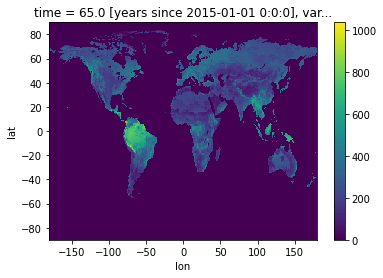

In [26]:
    sumbin_future.plot()

In [1]:
import pandas as pd

# Data for "Future" and "Historical"
data_future = {
    'rcp26': [18867210.00, 1816327.00, 4728169.00, 3148749.00, 683888.40, 4491218.00, 11860040.00, 12398060.00, 0.00, 1285500.00, 3247424.00, 1808931.00, 1162220.00],
    'rcp60': [18974260.00, 1814528.00, 4617070.00, 3141142.00, 667521.00, 4351024.00, 12114740.00, 12158330.00, 0.00, 1277629.00, 3224636.00, 1771682.00, 1129017.00],
    'Climate Change': [11577810, 1058225, 2922221, 1861747, 400770.9, 2921824, 7336646, 7891339, 0, 885276.3, 1925629, 1116051, 596439.3],
    'Climate and Land Use Change': [11207150, 985872.4, 2020956, 1835290, 370142.7, 2813959, 7490011, 6911186, 0, 867359.7, 1823188, 957721, 567692.4]
}

data_historical = {
    'rcp26': [18289880.00, 1841013.00, 4770230.00, 3060936.00, 733914.00, 4587273.00, 11177230.00, 12600410.00, 0.00, 1287166.00, 3207020.00, 1855389.00, 1160949.00],
    'rcp60': [18289880.00, 1841013.00, 4770230.00, 3060936.00, 733914.00, 4587273.00, 11177230.00, 12600410.00, 0.00, 1287166.00, 3207020.00, 1855389.00, 1160949.00],
    'Climate Change': [10886790.00, 1055497.00, 2897071.00, 1731626.00, 425687.70, 3052715.00, 6673647.00, 7969626.00, 0.00, 890196.70, 1784848.00, 1165783.00, 582539.90],
    'Climate and Land Use Change': [10886790.00, 1055497.00, 2897071.00, 1731626.00, 425687.70, 3052715.00, 6673647.00, 7969626.00, 0.00, 890196.70, 1784848.00, 1165783.00, 582539.90]
}

# Convert data to DataFrames
df_future = pd.DataFrame(data_future, index=['North America', 'South Asia', 'Sub-saharan Africa', 'Central and Western Europe', 'Western Asia', 'South America', 'Eastern Europe', 'Oceania', 'NaN', 'South-East Asia', 'North-East Asia', 'North Africa', 'Central Asia'])
df_historical = pd.DataFrame(data_historical, index=['North America', 'South Asia', 'Sub-saharan Africa', 'Central and Western Europe', 'Western Asia', 'South America', 'Eastern Europe', 'Oceania', 'NaN', 'South-East Asia', 'North-East Asia', 'North Africa', 'Central Asia'])

# Calculate relative differences
relative_differences = ((df_future - df_historical) / df_historical) * 100

# Print the relative differences
print("Relative Differences (%):")
print(relative_differences)


Relative Differences (%):
                               rcp26     rcp60  Climate Change  \
North America               3.156554  3.741851        6.347326   
South Asia                 -1.340892 -1.438610        0.258456   
Sub-saharan Africa         -0.881739 -3.210747        0.868118   
Central and Western Europe  2.868828  2.620310        7.514382   
Western Asia               -6.816275 -9.046428       -5.853305   
South America              -2.093946 -5.150097       -4.287691   
Eastern Europe              6.108938  8.387677        9.934583   
Oceania                    -1.605900 -3.508457       -0.982317   
NaN                              NaN       NaN             NaN   
South-East Asia            -0.129432 -0.740930       -0.552732   
North-East Asia             1.259861  0.549295        7.887562   
North Africa               -2.503949 -4.511561       -4.265974   
Central Asia                0.109479 -2.750508        2.386000   

                            Climate and Land Use 

ValueError: aspect must be finite and positive 

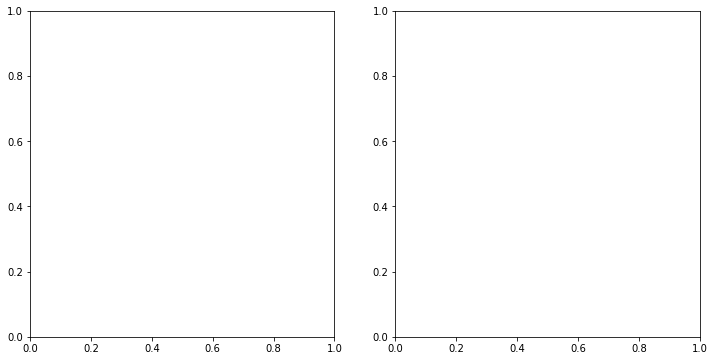

In [6]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Assuming you have a GeoDataFrame named 'world' with the geometries for each region
# Replace 'world' with your actual GeoDataFrame

# Define the data with climate change impact only
data_climate_change = {
    'rcp26': [3.156554, -1.340892, -0.881739, 2.868828, -6.816275, -2.093946, 6.108938, -1.6059, -0.129432, 1.259861, -2.503949, 0.109479],
    'rcp60': [3.741851, -1.43861, -3.210747, 2.62031, -9.046428, -5.150097, 8.387677, -3.508457, -0.74093, 0.549295, -4.511561, -2.750508],
}

# Convert data to DataFrame
df_climate_change = pd.DataFrame(data_climate_change, index=['North America', 'South Asia', 'Sub-saharan Africa', 'Central and Western Europe', 'Western Asia', 'South America', 'Eastern Europe', 'Oceania', 'South-East Asia', 'North-East Asia', 'North Africa', 'Central Asia'])

# Merge GeoDataFrame with DataFrame containing climate change impact
world_climate_change = shp.merge(df_climate_change, left_index=True, right_index=True)

# Plot the choropleth map
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# RCP 2.6
world_climate_change.plot(column='rcp26', cmap='coolwarm', linewidth=0.8, ax=ax[0], edgecolor='0.8', legend=True)
ax[0].set_title('Climate Change Impact (RCP 2.6)')

# RCP 6.0
world_climate_change.plot(column='rcp60', cmap='coolwarm', linewidth=0.8, ax=ax[1], edgecolor='0.8', legend=True)
ax[1].set_title('Climate Change Impact (RCP 6.0)')

plt.show()


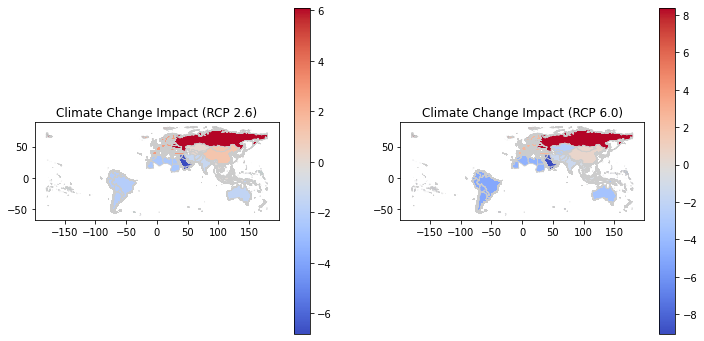

In [7]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have a GeoDataFrame named 'shp' with the corrected region mapping and 'new_region' column
# Replace 'shp' with your actual GeoDataFrame

# Define the data with climate change impact
data_climate_change = {
    'rcp26': [3.156554, -1.340892, -0.881739, 2.868828, -6.816275, -2.093946, 6.108938, -1.6059, -0.129432, 1.259861, -2.503949, 0.109479],
    'rcp60': [3.741851, -1.43861, -3.210747, 2.62031, -9.046428, -5.150097, 8.387677, -3.508457, -0.74093, 0.549295, -4.511561, -2.750508],
}

# Convert data to DataFrame
df_climate_change = pd.DataFrame(data_climate_change, index=['Caribbean', 'South Asia', 'Southern Africa', 'Central and Western Europe', 'Western Asia', 'South America', 'Eastern Europe', 'Oceania', 'South-East Asia', 'North-East Asia', 'North Africa', 'Central Asia'])

# Merge GeoDataFrame with DataFrame containing climate change impact
shp_climate_change = shp.merge(df_climate_change, left_on='new_region', right_index=True)

# Plot the choropleth map
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# RCP 2.6
shp_climate_change.plot(column='rcp26', cmap='coolwarm', linewidth=0.8, ax=ax[0], edgecolor='0.8', legend=True)
ax[0].set_title('Climate Change Impact (RCP 2.6)')

# RCP 6.0
shp_climate_change.plot(column='rcp60', cmap='coolwarm', linewidth=0.8, ax=ax[1], edgecolor='0.8', legend=True)
ax[1].set_title('Climate Change Impact (RCP 6.0)')

plt.show()


In [ ]:
# Create an empty dictionary to store mean species richness for each region and each scenario
mean_species_richness_dict = {'newvalue_future': {}, 'sumbin_future': {}, 'newvalue_hist': {}, 'sumbin_hist': {}, 'diff_newvalue': {}, 'diff_sumbin': {}}

scenarios = ["rcp26","rcp60"]
historical_time= 1146
future_time=65

# Iterate through unique new regions
for new_region in shp['new_region'].unique():
    # Select the region-specific geometry from the shapefile
    region_gdf = shp[shp['new_region'] == new_region]

    for scenario in scenarios:
        # Open datasets for the current scenario
        newvalue_future = xr.open_dataset(f"/storage/scratch/users/ch21o450/data/SR/SR_CC_{future_time}_{scenario}.nc", decode_times=False).to_array().isel(variable=0)
        sumbin_future = xr.open_dataset(f"/storage/scratch/users/ch21o450/data/SR/SR_CCLUC_{future_time}_{scenario}.nc", decode_times=False).to_array().isel(time=0)
        sumbin_future = sumbin_future.isel(variable=0)

        newvalue_hist = xr.open_dataset(f"/storage/scratch/users/ch21o450/data/SR/SR_CC_{historical_time}_{scenario}.nc", decode_times=False).to_array().isel(variable=0)
        sumbin_hist = xr.open_dataset(f"/storage/scratch/users/ch21o450/data/SR/SR_CCLUC_{historical_time}_{scenario}.nc", decode_times=False).to_array().isel(variable=0)

        # Calculate differences
        diff_newvalue = newvalue_future - newvalue_hist
        diff_sumbin = sumbin_future - sumbin_hist

        # Extract the bounding box coordinates
        minx, miny, maxx, maxy = region_gdf.geometry.total_bounds

        # Create a boolean mask based on the bounding box
        mask = (
            (newvalue_future.lon >= minx) & (newvalue_future.lon <= maxx) &
            (newvalue_future.lat >= miny) & (newvalue_future.lat <= maxy)
        )

        # Apply the mask to the DataArrays
        region_data = {
            'newvalue_future': newvalue_future.where(mask),
            'sumbin_future': sumbin_future.where(mask),
            'newvalue_hist': newvalue_hist.where(mask),
            'sumbin_hist': sumbin_hist.where(mask),
            'diff_newvalue': diff_newvalue.where(mask),
            'diff_sumbin': diff_sumbin.where(mask)
        }

        # Calculate mean species richness for each variable
        for variable, data_array in region_data.items():
            mean_species_richness = data_array.sum(dim=['lat', 'lon']).item()
            mean_species_richness_dict[variable].setdefault(new_region, {})[scenario] = mean_species_richness



# Print the tables
for variable, region_data_dict in mean_species_richness_dict.items():
    print(f"\n{variable} Mean Species Richness:")
    result_df = pd.DataFrame(region_data_dict).transpose()
    print(result_df)


newvalue_future Mean Species Richness:
                                           rcp26         rcp60
NaN                                 1.239806e+07  1.215833e+07
Central, North-East & South Asi     1.239806e+07  1.215833e+07
West, Central, East & South Africa  1.239806e+07  1.215833e+07
Central and Western Europe          1.239806e+07  1.215833e+07
North Africa & Western Asia         1.239806e+07  1.215833e+07
South America                       1.239806e+07  1.215833e+07
Eastern Europe                      1.239806e+07  1.215833e+07
Oceania                             1.239806e+07  1.215833e+07
Caribbean & Mesoamerica             1.239806e+07  1.215833e+07
South-East Asia                     1.239806e+07  1.215833e+07
North America                       1.239806e+07  1.215833e+07
Central, North-East & South Asia    1.239806e+07  1.215833e+07

sumbin_future Mean Species Richness:
                                           rcp26         rcp60
NaN                                 7.89

In [25]:
# Check for oceania

mean_species_richness_dict = {'newvalue_future': {}, 'sumbin_future': {}, 'newvalue_hist': {}, 'sumbin_hist': {}, 'diff_newvalue': {}, 'diff_sumbin': {}}

scenarios = ["rcp26","rcp60"]
historical_time= 1146
future_time=65

# Iterate through unique new regions
for new_region in shp['new_region'].unique():
    # Select the region-specific geometry from the shapefile
    region_gdf = shp[shp['new_region'] == 'Oceania']

    for scenario in scenarios:
        # Open datasets for the current scenario
        newvalue_future = xr.open_dataset(f"/storage/scratch/users/ch21o450/data/SR/SR_CC_{future_time}_{scenario}.nc", decode_times=False).to_array().isel(variable=0)
        sumbin_future = xr.open_dataset(f"/storage/scratch/users/ch21o450/data/SR/SR_CCLUC_{future_time}_{scenario}.nc", decode_times=False).to_array().isel(time=0)
        sumbin_future = sumbin_future.isel(variable=0)

        newvalue_hist = xr.open_dataset(f"/storage/scratch/users/ch21o450/data/SR/SR_CC_{historical_time}_{scenario}.nc", decode_times=False).to_array().isel(variable=0)
        sumbin_hist = xr.open_dataset(f"/storage/scratch/users/ch21o450/data/SR/SR_CCLUC_{historical_time}_{scenario}.nc", decode_times=False).to_array().isel(variable=0)

        # Calculate differences
        diff_newvalue = newvalue_future - newvalue_hist
        diff_sumbin = sumbin_future - sumbin_hist

        # Extract the bounding box coordinates
        minx, miny, maxx, maxy = region_gdf.geometry.total_bounds

        # Create a boolean mask based on the bounding box
        mask = (
            (newvalue_future.lon >= minx) & (newvalue_future.lon <= maxx) &
            (newvalue_future.lat >= miny) & (newvalue_future.lat <= maxy)
        )

        # Apply the mask to the DataArrays
        region_data = {
            'newvalue_future': newvalue_future.where(mask),
            'sumbin_future': sumbin_future.where(mask),
            'newvalue_hist': newvalue_hist.where(mask),
            'sumbin_hist': sumbin_hist.where(mask),
            'diff_newvalue': diff_newvalue.where(mask),
            'diff_sumbin': diff_sumbin.where(mask)
        }

        # Calculate mean species richness for each variable
        for variable, data_array in region_data.items():
            mean_species_richness = data_array.sum(dim=['lat', 'lon']).item()
            mean_species_richness_dict[variable].setdefault(new_region, {})[scenario] = mean_species_richness



# Print the tables
for variable, region_data_dict in mean_species_richness_dict.items():
    #print(f"\n{variable} Mean Species Richness:")
    result_df = pd.DataFrame(region_data_dict).transpose()
    #print(result_df)

In [30]:
mean_species_richness_dict["newvalue_future"]

{'North America': {'rcp26': 12398059.482847653, 'rcp60': 12158327.842496192},
 'South Asia': {'rcp26': 12398059.482847653, 'rcp60': 12158327.842496192},
 'Sub-saharan Africa': {'rcp26': 12398059.482847653,
  'rcp60': 12158327.842496192},
 'Central and Western Europe': {'rcp26': 12398059.482847653,
  'rcp60': 12158327.842496192},
 'Western Asia': {'rcp26': 12398059.482847653, 'rcp60': 12158327.842496192},
 'South America': {'rcp26': 12398059.482847653, 'rcp60': 12158327.842496192},
 'Eastern Europe': {'rcp26': 12398059.482847653, 'rcp60': 12158327.842496192},
 'Oceania': {'rcp26': 12398059.482847653, 'rcp60': 12158327.842496192},
 nan: {'rcp26': 12398059.482847653, 'rcp60': 12158327.842496192},
 'South-East Asia': {'rcp26': 12398059.482847653, 'rcp60': 12158327.842496192},
 'North-East Asia': {'rcp26': 12398059.482847653, 'rcp60': 12158327.842496192},
 'North Africa': {'rcp26': 12398059.482847653, 'rcp60': 12158327.842496192},
 'Central Asia': {'rcp26': 12398059.482847653, 'rcp60': 1215

In [20]:
import pandas as pd

# Given data
climate_change_only = [3.741851, -1.43861, -3.210747, 2.62031, -9.046428, -5.150097, 8.387677, -3.508457, -0.74093, 0.549295, -4.511561, -2.750508]
climate_land_use_change = [2.942649, -6.596381, -30.241406, 5.986512, -13.048298, -7.821104, 12.232652, -13.280924, -2.565388, 2.148082, -17.847404, -2.548752]

# Convert data to DataFrames
df_climate_change_only = pd.DataFrame({'rcp60': climate_change_only})
df_climate_land_use_change = pd.DataFrame({'rcp60': climate_land_use_change})

# Calculate relative differences
relative_differences = ((df_climate_change_only - df_climate_land_use_change) / df_climate_land_use_change) * 100

# Print the relative differences
print("Relative Differences (%):")
print(relative_differences)


Relative Differences (%):
        rcp60
0   27.159270
1  -78.190920
2  -89.382944
3  -56.229771
4  -30.669670
5  -34.151278
6  -31.432064
7  -73.582734
8  -71.118209
9  -74.428583
10 -74.721472
11   7.915874


In [16]:
#use the netcdf masks instead of working from the shapefile 

import xarray as xr
import pandas as pd

# Assuming you have already read the shapefile and created the 'new_region' column
# If not, include the relevant code for reading and creating the 'new_region' column from your previous messages

regionlist = ['West, Central, East & South Africa', 'Central and Western Europe', 'North Africa & Western Asia', 'South America', 'Eastern Europe', 'Oceania', 'Caribbean & Mesoamerica', 'South-East Asia', 'North America', 'Central, North-East & South Asia']

# Create an empty dictionary to store mean species richness for each region and each scenario
mean_species_richness_dict = {'newvalue_future': {}, 'sumbin_future': {}, 'newvalue_hist': {}, 'sumbin_hist': {}, 'diff_newvalue': {}, 'diff_sumbin': {}}

scenarios = ["rcp26", "rcp60"]
historical_time = 1146
future_time = 65

for region in regionlist:
    # Open the NetCDF file with the mask for the current region
    oceanic = xr.open_dataset(f"/storage/workspaces/wa_climate/climate_trt/chari/IPBES_subregions/output_{region}_data.nc", decode_times=False)
    oceania_mask_renamed = oceanic.rename({'longitude': 'lon', 'latitude': 'lat'})[f"{region}_data"]

    # Open the newvalue_future dataset
    newvalue_future_path = "/storage/scratch/users/ch21o450/data/SR/SR_CC_65_rcp60.nc"
    newvalue_future = xr.open_dataset(newvalue_future_path, decode_times=False).to_array().isel(variable=0)

    oceania_mask_renamed = oceania_mask_renamed.interp(lat=newvalue_future['lat'], lon=newvalue_future['lon'], method='nearest')

    # Create a sub-dictionary for the current region
    region_dict = {'newvalue_future': {}, 'sumbin_future': {}, 'newvalue_hist': {}, 'sumbin_hist': {}, 'diff_newvalue': {}, 'diff_sumbin': {}}

    for scenario in scenarios:
        # Open datasets for the current scenario
        newvalue_future = xr.open_dataset(f"/storage/scratch/users/ch21o450/data/SR/SR_CC_{future_time}_{scenario}.nc", decode_times=False).to_array().isel(variable=0)
        sumbin_future = xr.open_dataset(f"/storage/scratch/users/ch21o450/data/SR/SR_CCLUC_{future_time}_{scenario}.nc", decode_times=False).to_array().isel(time=0)
        sumbin_future = sumbin_future.isel(variable=0)

        newvalue_hist = xr.open_dataset(f"/storage/scratch/users/ch21o450/data/SR/SR_CC_{historical_time}_{scenario}.nc", decode_times=False).to_array().isel(variable=0)
        sumbin_hist = xr.open_dataset(f"/storage/scratch/users/ch21o450/data/SR/SR_CCLUC_{historical_time}_{scenario}.nc", decode_times=False).to_array().isel(variable=0)

        # Calculate differences
        diff_newvalue = newvalue_future - newvalue_hist
        diff_sumbin = sumbin_future - sumbin_hist

        # Apply the mask to the DataArrays
        region_data = {
            'newvalue_future': newvalue_future.where(oceania_mask_renamed == 1),
            'sumbin_future': sumbin_future.where(oceania_mask_renamed == 1),
            'newvalue_hist': newvalue_hist.where(oceania_mask_renamed == 1),
            'sumbin_hist': sumbin_hist.where(oceania_mask_renamed == 1),
            'diff_newvalue': diff_newvalue.where(oceania_mask_renamed == 1),
            'diff_sumbin': diff_sumbin.where(oceania_mask_renamed == 1)
        }

        # Calculate mean species richness for each variable
        for variable, data_array in region_data.items():
            mean_species_richness = data_array.sum(dim=['lat', 'lon']).item()
            region_dict[variable][scenario] = mean_species_richness

    # Store the sub-dictionary in the main dictionary for the current region
    mean_species_richness_dict['newvalue_future'][region] = region_dict['newvalue_future']
    mean_species_richness_dict['sumbin_future'][region] = region_dict['sumbin_future']
    mean_species_richness_dict['newvalue_hist'][region] = region_dict['newvalue_hist']
    mean_species_richness_dict['sumbin_hist'][region] = region_dict['sumbin_hist']
    mean_species_richness_dict['diff_newvalue'][region] = region_dict['diff_newvalue']
    mean_species_richness_dict['diff_sumbin'][region] = region_dict['diff_sumbin']

# Print the tables
for variable, region_data_dict in mean_species_richness_dict.items():
    print(f"\n{variable} Mean Species Richness:")
    result_df = pd.DataFrame(region_data_dict).transpose()
    print(result_df)



newvalue_future Mean Species Richness:
                                           rcp26         rcp60
West, Central, East & South Africa  4.157082e+06  4.046254e+06
Central and Western Europe          1.755259e+06  1.752219e+06
North Africa & Western Asia         1.301944e+06  1.285749e+06
South America                       3.922146e+06  3.805098e+06
Eastern Europe                      4.522877e+06  4.701266e+06
Oceania                             1.192371e+06  1.202880e+06
Caribbean & Mesoamerica             5.231974e+05  5.025405e+05
South-East Asia                     9.683267e+05  9.689987e+05
North America                       4.987356e+06  5.057086e+06
Central, North-East & South Asia    7.168394e+05  6.952310e+05

sumbin_future Mean Species Richness:
                                           rcp26         rcp60
West, Central, East & South Africa  2.561076e+06  1.671376e+06
Central and Western Europe          1.049689e+06  1.029801e+06
North Africa & Western Asia         8.08

In [29]:
import pandas as pd

# Define the historical and future dataframes
historical_data = {
    'Climate Change rcp26': [4165307.00, 1695179.00, 1378747.00, 4000859.00, 4116140.00, 1242448.00, 546767.10, 968416.60, 4786400.00, 713837.30],
    'Climate Change rcp60': [4165307.00, 1695179.00, 1378747.00, 4000859.00, 4116140.00, 1242448.00, 546767.10, 968416.60, 4786400.00, 713837.30],
    'CCLUC rcp26': [2507093.00, 948270.60, 872789.80, 2718619.00, 2770635.00, 704850.70, 308299.40, 684112.00, 2715577.00, 341808.20],
    'CCLUC rcp60': [2507093.00, 948270.60, 872789.80, 2718619.00, 2770635.00, 704850.70, 308299.40, 684112.00, 2715577.00, 341808.20]
}

future_data = {
    'Climate Change rcp26': [4157082.00, 1755259.00, 1301944.00, 3922146.00, 4522877.00, 1192371.00, 523197.40, 968326.70, 4987356.00, 716839.40],
    'Climate Change rcp60': [4046254.00, 1752219.00, 1285749.00, 3805098.00, 4701266.00, 1202880.00, 502540.50, 968998.70, 5057086.00, 695231.00],
    'CCLUC rcp26': [2561076.00, 1049689.00, 808721.80, 2605632.00, 3113581.00, 722207.80, 303091.70, 665766.00, 2903401.00, 346823.80],
    'CCLUC rcp60': [1671376.00, 1029801.00, 786675.00, 2601597.00, 3245532.00, 714956.60, 271109.60, 661879.70, 2930488.00, 330869.90]
}

# Convert data to dataframes
historical_df = pd.DataFrame(historical_data, index=['West, Central, East & South Africa', 'Central and Western Europe', 'North Africa & Western Asia', 'South America', 'Eastern Europe', 'Oceania', 'Caribbean & Mesoamerica', 'South-East Asia', 'North America', 'Central, North-East & South Asia'])
future_df = pd.DataFrame(future_data, index=['West, Central, East & South Africa', 'Central and Western Europe', 'North Africa & Western Asia', 'South America', 'Eastern Europe', 'Oceania', 'Caribbean & Mesoamerica', 'South-East Asia', 'North America', 'Central, North-East & South Asia'])

# Calculate relative differences
relative_diff_df = ((future_df - historical_df) / historical_df) * 100

# Print the result
print("Relative Differences Historic to Future (%):")
print(relative_diff_df)


Relative Differences Historic to Future (%):
                                    Climate Change rcp26  \
West, Central, East & South Africa             -0.197464   
Central and Western Europe                      3.544168   
North Africa & Western Asia                    -5.570493   
South America                                  -1.967403   
Eastern Europe                                  9.881515   
Oceania                                        -4.030511   
Caribbean & Mesoamerica                        -4.310739   
South-East Asia                                -0.009283   
North America                                   4.198479   
Central, North-East & South Asia                0.420558   

                                    Climate Change rcp60  CCLUC rcp26  \
West, Central, East & South Africa             -2.858205     2.153211   
Central and Western Europe                      3.364836    10.695091   
North Africa & Western Asia                    -6.745110    -7.340599   
So

In [35]:
import numpy as np

# Provided values
cc_values = np.array([-119053.47, 57040.34, -92998.06, -195761.57, 585125.63, -39567.52, -44226.60, 582.06, 270685.83, -18606.33])
ccluc_values = np.array([-835717.39, 81530.83, -86114.72, -117022.31, 474897.06, 10105.94, -37189.84, -22232.31, 214910.66, -10938.27])

# Calculate relative difference (%)
relative_difference = ((ccluc_values - cc_values) / np.abs(cc_values)) * 100

# Print the result
print("Relative Difference from cc to ccluc (%):")
for value in relative_difference:
    print(f"{value:.2f}")


Relative Difference from cc to ccluc (%):
-601.97
42.94
7.40
40.22
-18.84
125.54
15.91
-3919.59
-20.61
41.21


In [41]:
# Create an empty dictionary to store mean species richness for each region and each scenario
mean_species_richness_dict = {'newvalue_future': {}, 'sumbin_future': {}, 'newvalue_hist': {}, 'sumbin_hist': {}, 'diff_newvalue': {}, 'diff_sumbin': {}}

scenarios = ["rcp26","rcp60"]
historical_time= 1146
future_time=65

# Iterate through unique new regions
for new_region in shp['new_region'].unique():
    # Select the region-specific geometry from the shapefile
    region_gdf = shp[shp['new_region'] == new_region]

    for scenario in scenarios:
        # Open datasets for the current scenario
        newvalue_future = xr.open_dataset(f"/storage/scratch/users/ch21o450/data/SR/SR_CC_{future_time}_{scenario}_SA.nc", decode_times=False).to_array().isel(variable=0)
        sumbin_future = xr.open_dataset(f"/storage/scratch/users/ch21o450/data/SR/SR_CCLUC_{future_time}_{scenario}_SA.nc", decode_times=False).to_array().isel(variable=0)

        newvalue_hist = xr.open_dataset(f"/storage/scratch/users/ch21o450/data/SR/SR_CC_{historical_time}_{scenario}_SA.nc", decode_times=False).to_array().isel(variable=0)
        sumbin_hist = xr.open_dataset(f"/storage/scratch/users/ch21o450/data/SR/SR_CCLUC_{historical_time}_{scenario}_SA.nc", decode_times=False).to_array().isel(variable=0)

        # Calculate differences
        diff_newvalue = newvalue_future - newvalue_hist
        diff_sumbin = sumbin_future - sumbin_hist

        # Extract the bounding box coordinates
        minx, miny, maxx, maxy = region_gdf.geometry.total_bounds

        # Create a boolean mask based on the bounding box
        mask = (
            (newvalue_future.lon >= minx) & (newvalue_future.lon <= maxx) &
            (newvalue_future.lat >= miny) & (newvalue_future.lat <= maxy)
        )

        # Apply the mask to the DataArrays
        region_data = {
            'newvalue_future': newvalue_future.where(mask),
            'sumbin_future': sumbin_future.where(mask),
            'newvalue_hist': newvalue_hist.where(mask),
            'sumbin_hist': sumbin_hist.where(mask),
            'diff_newvalue': diff_newvalue.where(mask),
            'diff_sumbin': diff_sumbin.where(mask)
        }

        # Calculate mean species richness for each variable
        for variable, data_array in region_data.items():
            mean_species_richness = data_array.sum(dim=['lat', 'lon']).item()
            mean_species_richness_dict[variable].setdefault(new_region, {})[scenario] = mean_species_richness



# Print the tables
for variable, region_data_dict in mean_species_richness_dict.items():
    print(f"\n{variable} Mean Species Richness:")
    result_df = pd.DataFrame(region_data_dict).transpose()
    print(result_df)

RuntimeError: NetCDF: HDF error